<center> <h1>Buidling a Correlation graph...</h1> </center>

We begin by loading the data, as described in the other notebook.

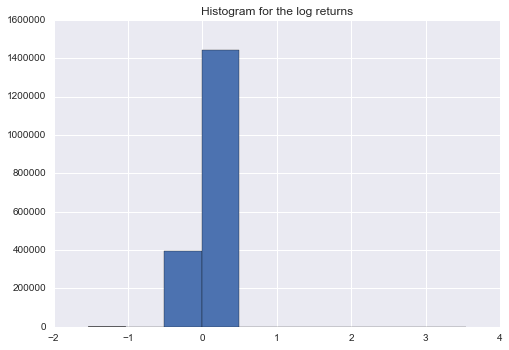

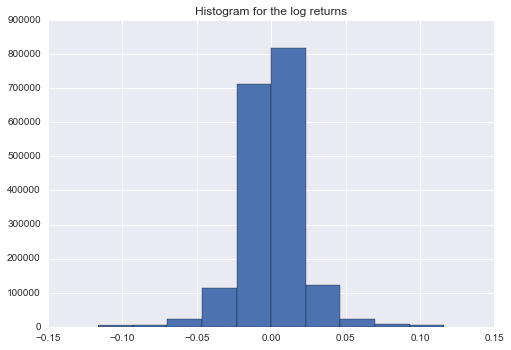

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sys
import quandl
from utils_preprocessing import *
from correlation import *
from market_alphas import *
from regression import *
from extract_sectors import *


path='/Users/cdonnat/Dropbox/Financial Networks/data/'
sys.path.append(path)
stock_data=pickle.load(open(path+'stock_data.pkl','rb'))
Volume_data=pickle.load(open(path+'volume_data.pkl','rb'))
new_stock_data,nb_missing_values,day_missing_values=treat_missing_data(stock_data,verbose=False)
data_log=transform_stock(new_stock_data)
verbose=True
if verbose==True:
    plt.figure()
    plt.hist(data_log.as_matrix().reshape([-1,1]))
    plt.title('Histogram for the log returns--before capping')
    plt.show()
##
### Cap some outliers
thres=5*(data_log.as_matrix().reshape([-1,1])).std()
data_log=data_log.applymap(lambda x: cap(x,thres))
if verbose==True:
        plt.figure()
        plt.hist(data_log.as_matrix().reshape([-1,1]))
        plt.title('Histogram for the log returns--after caping',bins=20)
        plt.show()




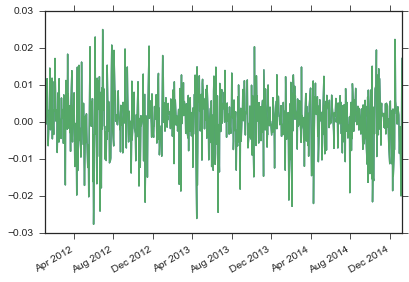

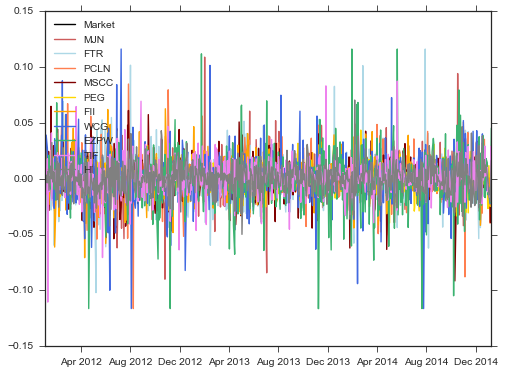

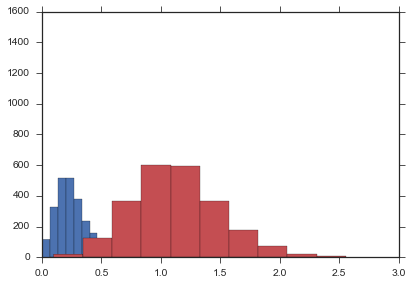

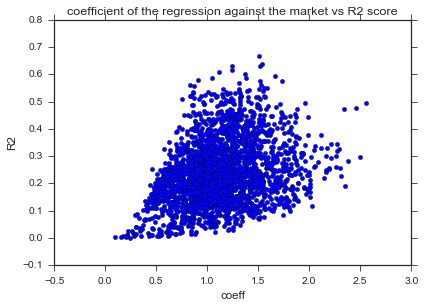

In [5]:
### threshold
stock_returns=data_log.copy()
r_m=compute_market_alpha(stock_data,stock_returns,Volume_data,plot=True)
r_m.plot()
from datetime import datetime
import matplotlib.dates as mdates
colors=['indianred','lightblue','coral','maroon','gold','orange','royalblue','mediumseagreen','violet','grey']
bunch=np.random.choice(data_log.columns,10)
fig, ax = plt.subplots(figsize=(8,6))
sns.set(style='ticks')
sns.set_context("paper", font_scale=1.3)
plt.plot_date(x=data_log.index, y=r_m,c='black',label='Market',fmt='-')
it_b=0
for b in bunch:
    plt.plot_date(x=data_log.index, y=data_log[b],c=colors[it_b],label=b,fmt='-')
    it_b+=1
plt.legend(loc='upper left')
plt.show()



coeff,intercept,MSE,R2=regress_stock_against_market(data_log,r_m,K=5)
## Check stuff out
plt.hist(R2.mean(0))
plt.hist(MSE.mean(0))
plt.hist(coeff.mean(0))
plt.figure()
plt.scatter(coeff.mean(0),R2.mean(0))
plt.xlabel('coeff')
plt.ylabel('R2')
plt.title('coefficient of the regression against the market vs R2 score')








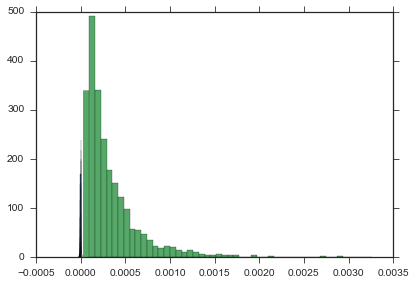

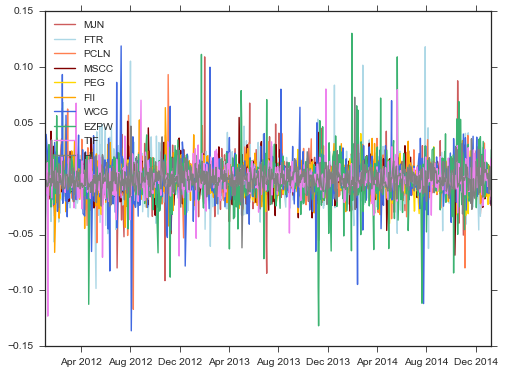

In [6]:
betas=pd.DataFrame(coeff.mean(0)).T
betas=pd.concat([betas]*data_log.shape[0], ignore_index=True)
betas.index=r_m.index
alphas=pd.DataFrame(intercept.mean(0)).T
alphas=pd.concat([alphas]*data_log.shape[0], ignore_index=True)
alphas.index=r_m.index
r_m_df=pd.concat([r_m]*data_log.shape[1], axis=1)
r_m_df.columns=betas.columns
market_effect=betas*r_m_df+alphas
stock_residuals=stock_returns-market_effect


### Compute a few statistics on the residualized returns:
plt.hist(stock_residuals.mean(0),bins=50)
plt.hist(stock_residuals.var(0),bins=50)

fig, ax = plt.subplots(figsize=(8,6))
sns.set(style='ticks')
sns.set_context("paper", font_scale=1.3)
it_b=0
for b in bunch:
    plt.plot_date(x=data_log.index, y=stock_residuals[b],c=colors[it_b],label=b,fmt='-')
    it_b+=1
plt.legend(loc='upper left')
plt.show()

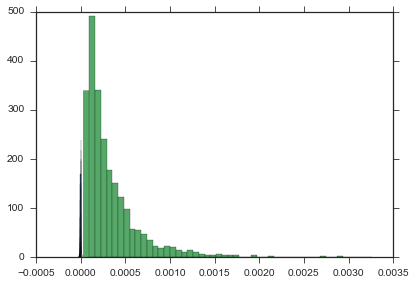

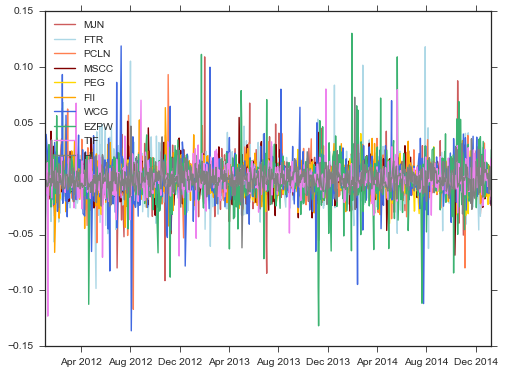

In [7]:
betas=pd.DataFrame(coeff.mean(0)).T
betas=pd.concat([betas]*data_log.shape[0], ignore_index=True)
betas.index=r_m.index
alphas=pd.DataFrame(intercept.mean(0)).T
alphas=pd.concat([alphas]*data_log.shape[0], ignore_index=True)
alphas.index=r_m.index
r_m_df=pd.concat([r_m]*data_log.shape[1], axis=1)
r_m_df.columns=betas.columns
market_effect=betas*r_m_df+alphas
stock_residuals=stock_returns-market_effect


### Compute a few statistics on the residualized returns:
plt.hist(stock_residuals.mean(0),bins=50)
plt.hist(stock_residuals.var(0),bins=50)

fig, ax = plt.subplots(figsize=(8,6))
sns.set(style='ticks')
sns.set_context("paper", font_scale=1.3)
it_b=0
for b in bunch:
    plt.plot_date(x=data_log.index, y=stock_residuals[b],c=colors[it_b],label=b,fmt='-')
    it_b+=1
plt.legend(loc='upper left')
plt.show()


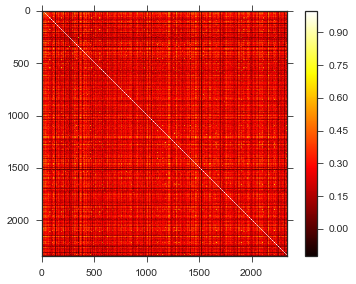

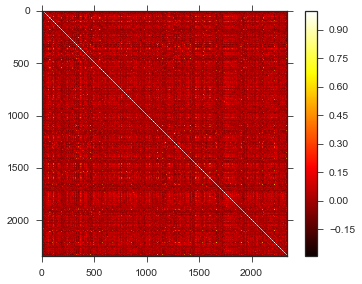

In [13]:
cor_returns=stock_returns.corr()
cor_res=stock_residuals.corr()

plt.figure()
plt.imshow(cor_returns,cmap='hot')
plt.colorbar()
plt.show()
#mask = np.ones(cor_returns.shape,dtype='bool')
#mask[np.tril_indices(cor_returns.shape[0])] = False
plt.figure()
plt.imshow(cor_res,cmap='hot')
plt.colorbar()
plt.show()



CompanySector,CompanyIndustry,CompanyInfo=load_sectors(path)
Betas=pd.DataFrame(betas.iloc[0,:])
Betas.columns=['beta']
Betas=Betas.merge(CompanyInfo.T,right_index=True,left_index=True)
Alphas=pd.DataFrame(alphas.iloc[0,:])
Alphas.columns=['alpha']

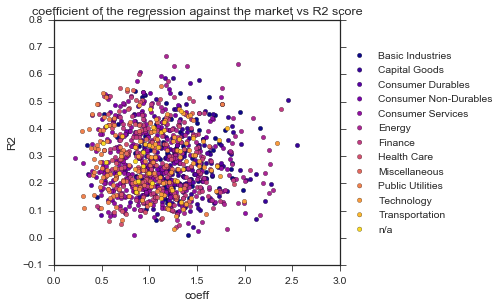

In [17]:
from consistency import *


Betas=Betas.merge(Alphas,right_index=True,left_index=True)
sec=pd.DataFrame(np.unique(Betas['Sector']))
sec['key_sector']=sec.index
ind=pd.DataFrame(np.unique(Betas['Industry']))
ind['key_industry']=ind.index
ind_beta=Betas.index
Betas=Betas.merge(sec,left_on='Sector',right_on=0)
Betas=Betas.merge(ind,left_on='Industry',right_on=0)
del Betas['0_y']
del Betas['0_x']
Betas.index=ind_beta
ind=pd.DataFrame(np.unique(Betas['Industry']))

x=np.linspace(0,1,sec.shape[0])
cmap=plt.get_cmap('plasma')
colors_sec={}
it=0
for u in sec[0]:
    colors_sec[u]=cmap(it*1.0/sec.shape[0])
    it+=1
R2_mean=pd.DataFrame(R2.mean(),index=R2.columns,columns=['R2'])
Betas=Betas.merge(R2_mean,right_index=True,left_index=True)
label_sec=[Betas.loc[u,'Sector'] for u in Betas.index]
label_colors=[colors_sec[Betas.loc[u,'Sector']] for u in Betas.index]
plt.figure()
ax = plt.subplot(111)
for s in sec[0]:
    ind_s=(Betas['Sector']==s)
    try:
        col=colors_sec[s]
    except:
        colors_sec[s]='black'
        col=colors_sec[s]
    plt.scatter(Betas.loc[ind_s,'beta'],Betas.loc[ind_s,'R2'],c=col,label=s)
plt.xlabel('coeff')
plt.ylabel('R2')
plt.title('coefficient of the regression against the market vs R2 score')
#plt.legend(loc='upper left')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()




Notes and observations:
+ This corresponds to a very limited amount of data. It needs to be extended to other time set. It also seems that this way of proceeding doesn't necessarily produce the same observations as when using the PCAA for instance...
+ 

0.05
0.0 1.0
0.075
0.0 1.0
0.1
0.0 1.0
0.125
0.0 1.0
0.15
0.0 1.0
0.175
0.0 1.0
0.2
0.0 1.0
0.4
0.0 1.0
0.5
0.0 1.0


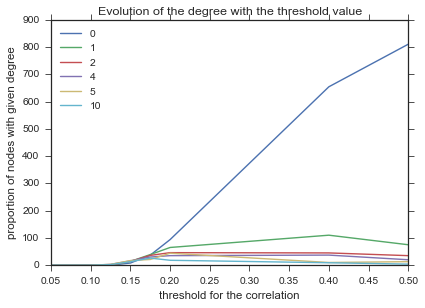

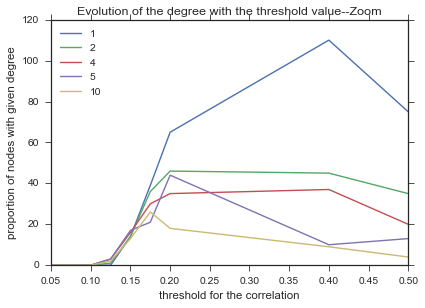

In [23]:

thres_array=np.sort([0.5,0.4,0.2,0.175,0.15,0.125,0.1,0.075,0.05])
degree=pd.DataFrame(np.zeros((Betas.shape[0],len(thres_array))),index=Betas.index,columns=thres_array)
consistency=pd.DataFrame(np.zeros((Betas.shape[0],len(thres_array))),index=Betas.index,columns=thres_array)
diversity=pd.DataFrame(np.zeros((Betas.shape[0],len(thres_array))),index=Betas.index,columns=thres_array)
cor_res=stock_residuals.corr()
for thres in thres_array:
    print thres
    cor_res=cor_res.applymap(lambda x: x*(np.abs(x)>thres))
    print np.min(np.min(np.abs(cor_res))),np.max(np.max(np.abs(cor_res)))
    ## Check diag
    sector_consistency_temp=sector_consistence(Betas,cor_res)
    consistency[thres]=sector_consistency_temp['consistency']
    diversity[thres]=sector_consistency_temp['diversity']
    degree[thres]=sector_consistency_temp['degree']
    #plt.hist(sector_consistency_temp['diversity'])
    #plt.hist(sector_consistency_temp['consistency'],bins=30)
    #plt.hist(sector_consistency_temp['degree'],bins=30)
    
### Most consistent stocks per threshold\
l={}
overlap=pd.DataFrame(np.zeros((Betas.shape[0],len(thres_array))),index=Betas.index,columns=thres_array)
for thres in thres_array:
    l[thres]=consistency[thres][consistency[thres].argsort()>Betas.shape[0]-200]
    overlap.loc[l[thres].index,thres]+=1
plt.figure()
for d in [0,1,2,4,5,10]:    
    plt.plot(thres_array,[np.sum(degree[t]==d) for t in thres_array],label=d)
plt.xlabel('threshold for the correlation')
plt.ylabel('proportion of nodes with given degree')
plt.title('Evolution of the degree with the threshold value')
plt.legend(loc='upper left')
plt.show()



plt.figure()
for d in [1,2,4,5,10]:    
    plt.plot(thres_array,[np.sum(degree[t]==d) for t in thres_array],label=d)
plt.xlabel('threshold for the correlation')
plt.ylabel('proportion of nodes with given degree')
plt.title('Evolution of the degree with the threshold value--Zoom')
plt.legend(loc='upper left')
plt.show()

For a threshold= 0.05


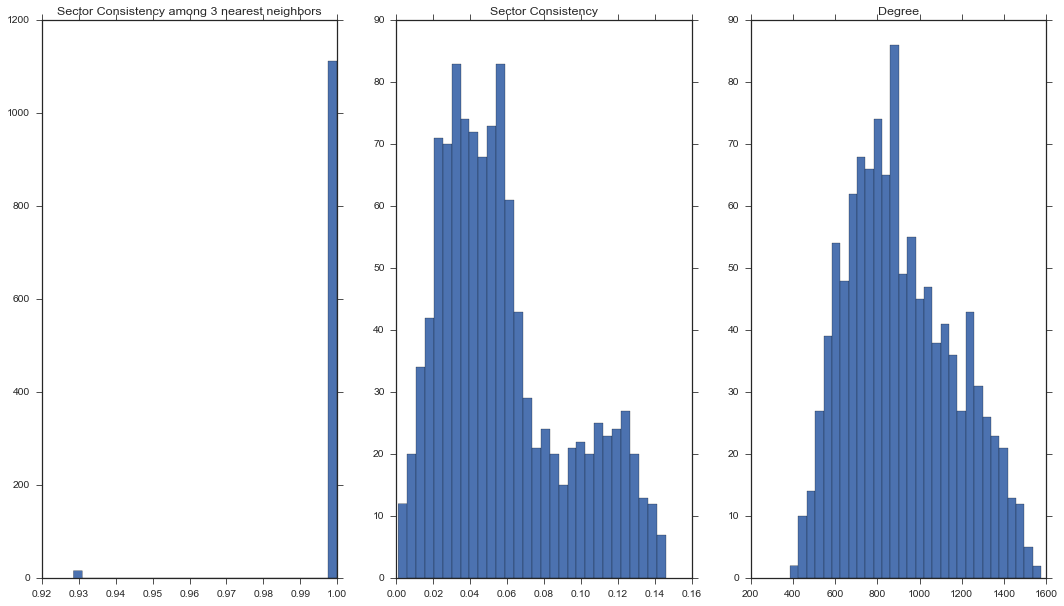

For a threshold= 0.075


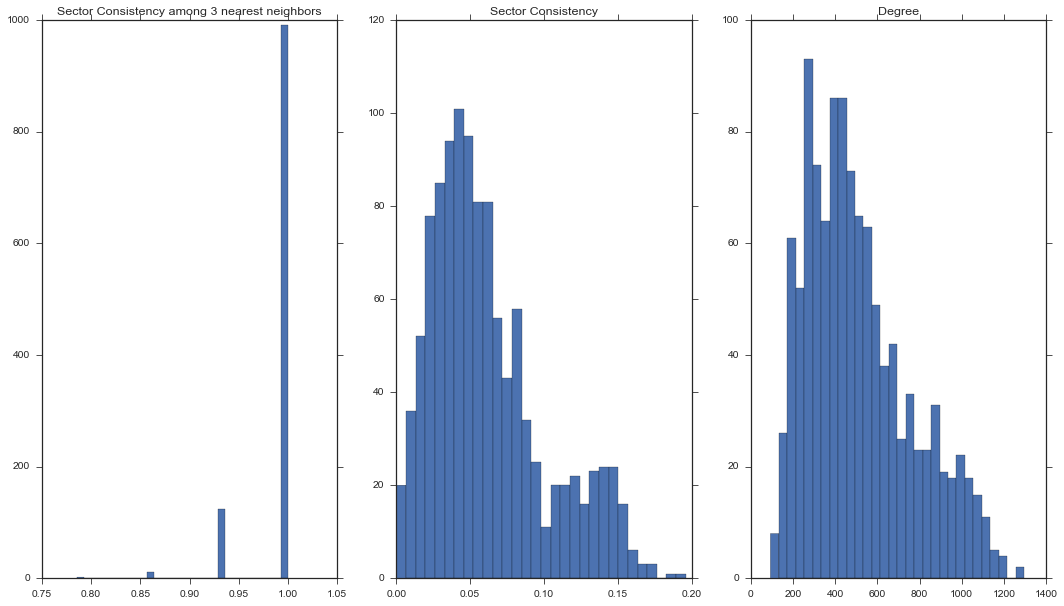

For a threshold= 0.1


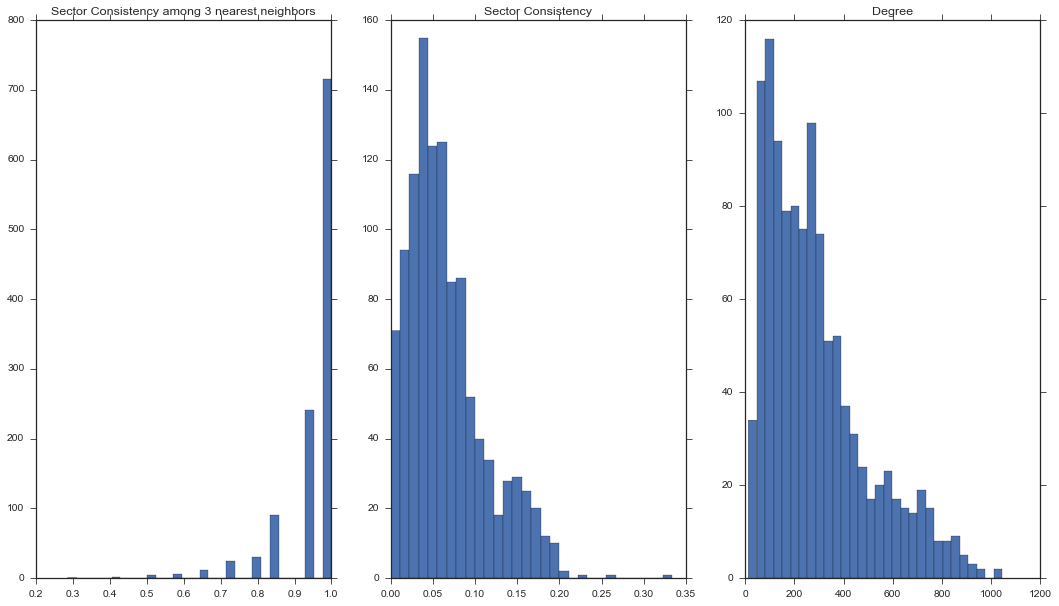

For a threshold= 0.125


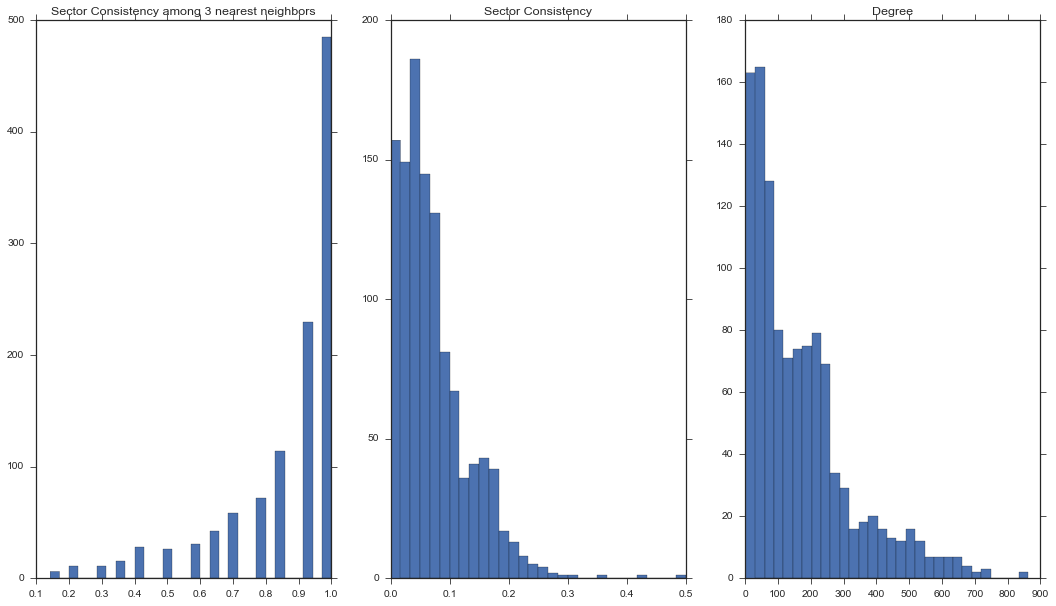

For a threshold= 0.15


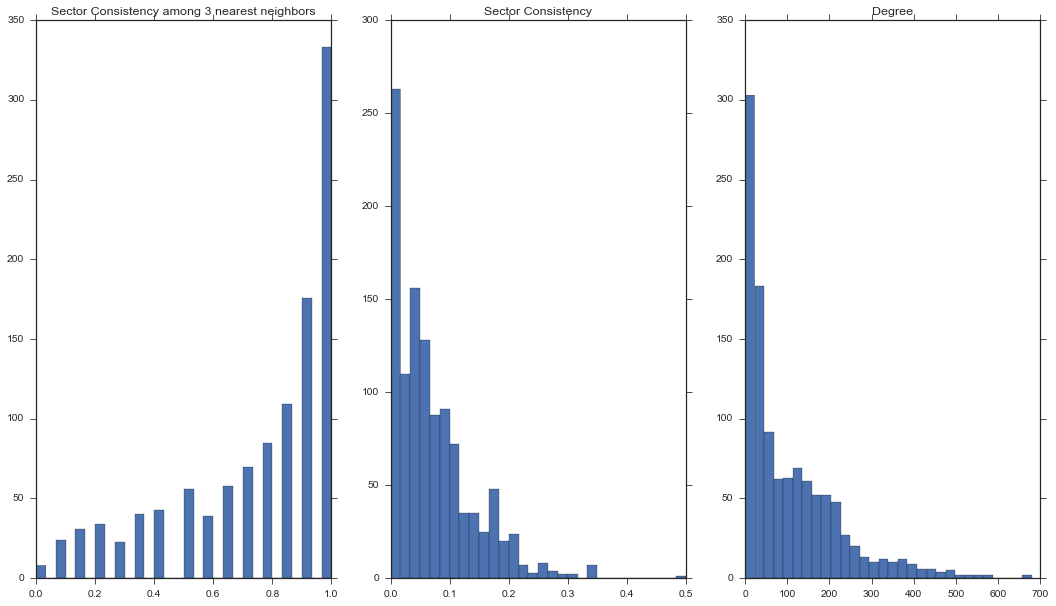

For a threshold= 0.175


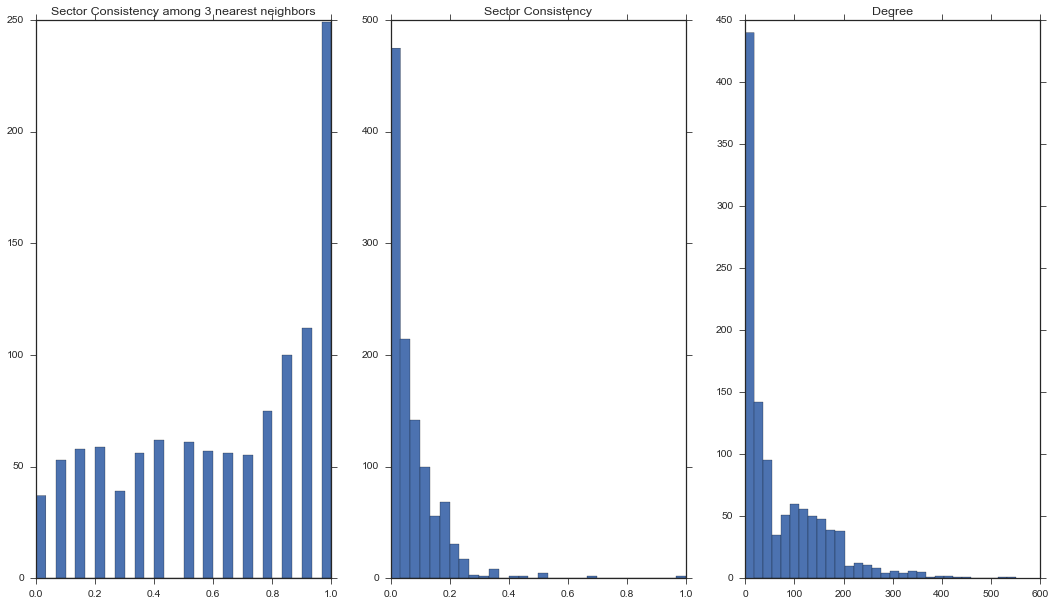

For a threshold= 0.2


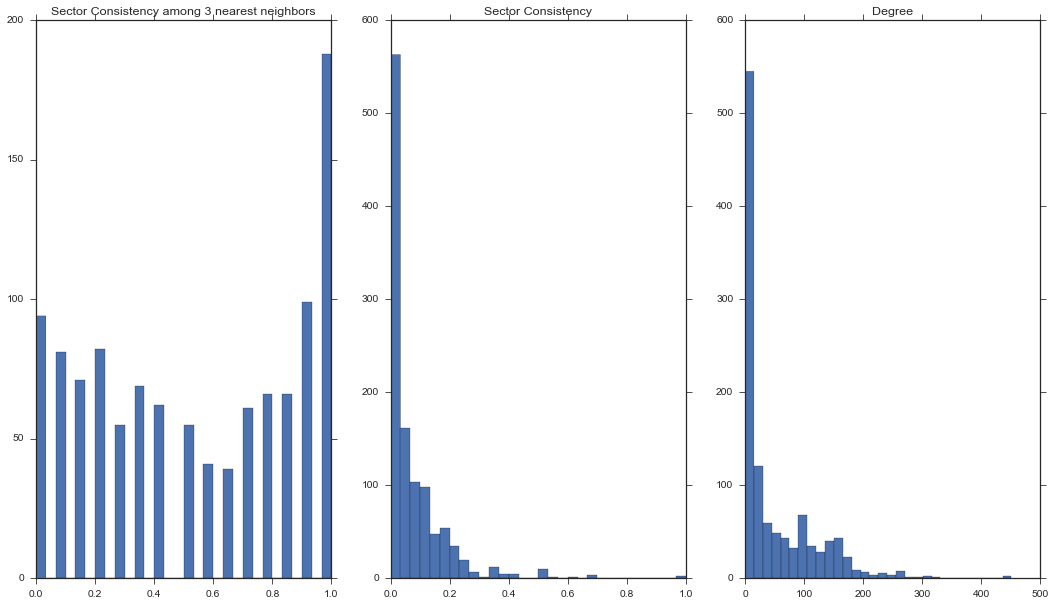

For a threshold= 0.4


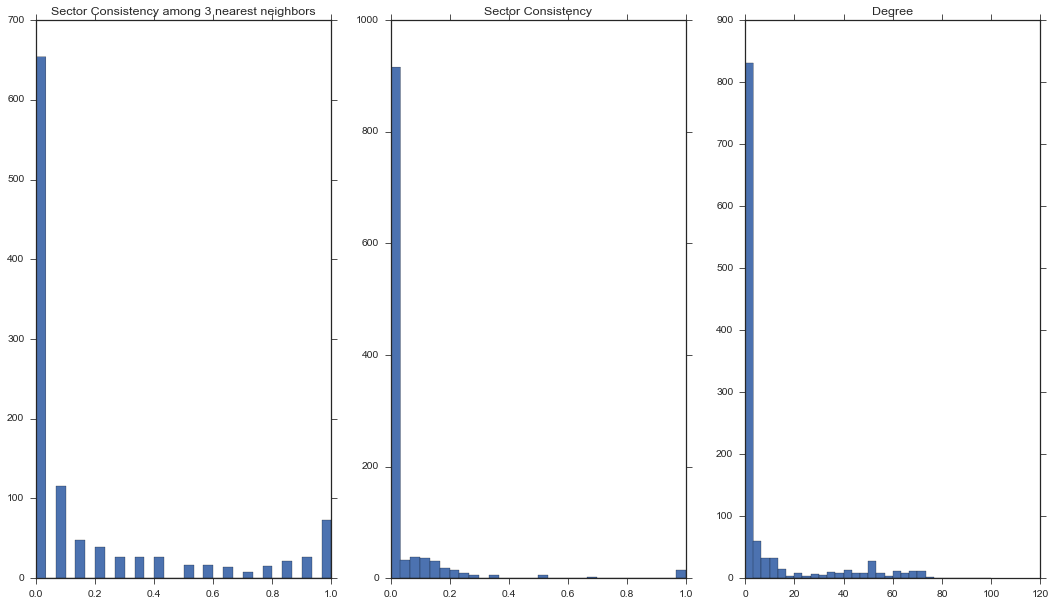

For a threshold= 0.5


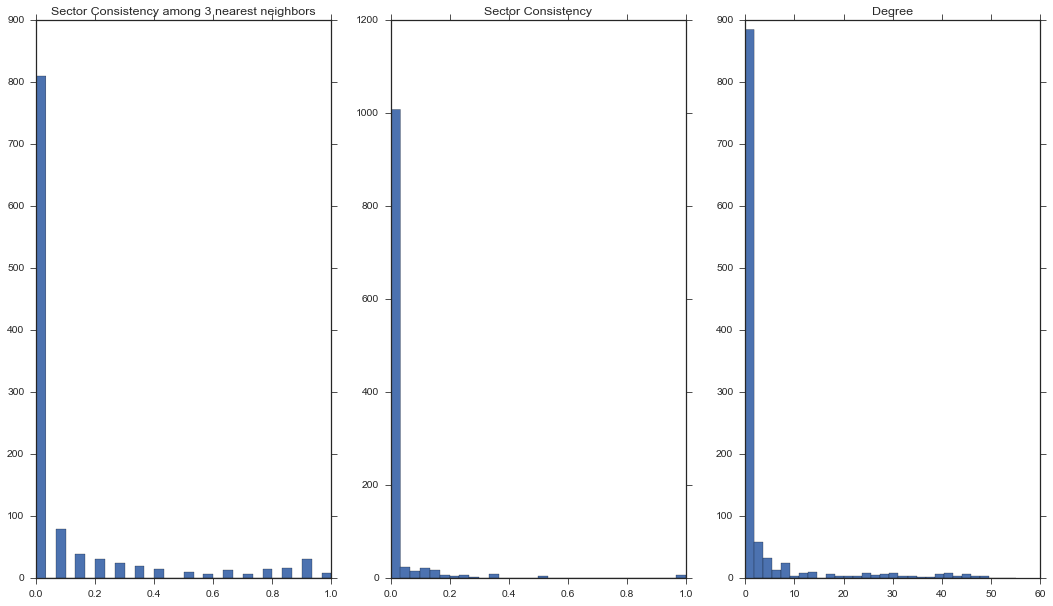

In [40]:
for thres in thres_array:
    print 'For a threshold=', thres
    fig,(ax1,ax2,ax3)=plt.subplots(1,3)
    fig.set_figwidth(18)
    fig.set_figheight(10)
    ax1.hist(diversity[thres].as_matrix(),bins=30)
    ax1.set_title('Sector Consistency among 3 nearest neighbors')
    ax2.hist(consistency[thres].as_matrix(),bins=30)
    ax2.set_title('Sector Consistency')
    ax3.hist(degree[thres].as_matrix(),bins=30)
    ax3.set_title('Degree of the resulting graph')
    plt.show()
    

In [22]:
graph_signal='no_go'
if graph_signal=='go':
    #### Decomposition in the eigenvalue sapce
    import pygsp
    Gg = pygsp.graphs.Graph(cor_res)
    Gg.compute_fourier_basis()
    D=np.zeros(Gg.N)
    D[:5]=Gg.e[:5]
    D=np.diag(D)
    Alt=Gg.U*D*U.T
#### Definition of a sufficient statisitic
### Distances between matrices

<h3><span style="color:purple">  Building A correlation Graph  </span></h3>


The idea here is that we might want to include higher order interactions between stocks, wthout making any assumpiton on their correlation structure,etc. In order to achieve this, we can use any king of copulas.

A few words on copulas:
The copula approach
is a useful method for deriving joint distributions given the marginal
distributions, especially when the variables are nonnormal. Second, in
a bivariate context, copulas can be used to define nonparametric measures
of dependence for pairs of random variables. When fairly general
and/or asymmetric modes of dependence are relevant, such as those
that go beyond correlation or linear association, then copulas play a
special role in developing additional concepts and measures. Finally,
copulas are useful extensions and generalizations of approaches for
modeling joint distributions and dependence that have appeared in
the literature. Sklar’s theorem provides a theoretical foundation for the application of copulas in describing the dependence structure of random variables. It states that every continuous multivariate distribution $F(X_1,\cdots, X_n)$ of a random vector $(X_1,\cdots, X_n)$ can be decomposed into marginal distributions $F_i(x)=\mathbb{P}(X_i <x)$  linked by a unique function $C$ called ‘copula’, such that:
$$F(x_1,\cdots, x_n)=C(F_1(x_1),\cdots, F_n(x_n))$$

In other words, an m-copula is an m-dimensional distribution function where all m univariate margins are uniformly distributed on [0,1].

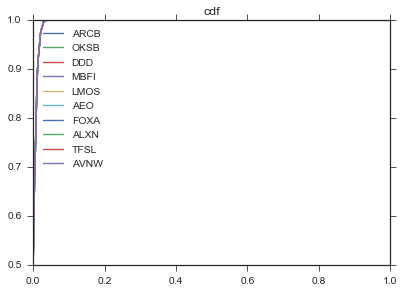

In [29]:
from cdf import *
cdf_dict=compute_cdf(stock_residuals)
bunch=np.random.choice(stock_residuals.columns, 10)
plt.figure()
x=np.linspace(0,1,500);
for b in bunch:
        plt.plot(x,[cdf(u,xx,cdf_dict) for xx in x],label=b)
plt.legend(loc="upper left")
plt.title("cdf")
plt.show()

cdf.py:62: RuntimeWarning: covariance is not positive-semidefinite.
  z=np.random.multivariate_normal(M,cor_transf)


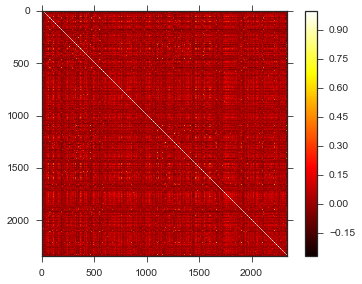

In [30]:

    
cdf_df,transf_df=transformation(stock_residuals,cdf_dict)
cor_transf=transf_df.corr()
plt.figure()
plt.imshow(cor_transf,cmap='hot')
plt.colorbar()
vm1=MC_sample(transf_df,cdf_dict,cor_transf=[],M=[])

The average difference in correlation is:  -0.0354398067575
The max difference in correlation is:  0.272764857512
The min difference in correlation is:  -0.594099931798


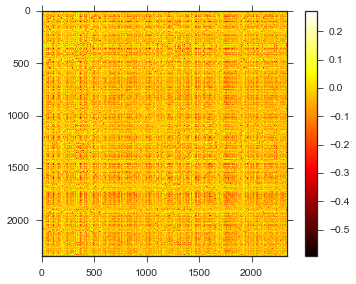

In [35]:
plt.imshow(cor_res-cor_transf,cmap='hot')
plt.colorbar()
print 'The average difference in correlation is: ',np.mean((cor_res-cor_transf).mean())
print 'The max difference in correlation is: ',np.max((cor_res-cor_transf).max())
print 'The min difference in correlation is: ',np.min((cor_res-cor_transf).min())

The proposed approach is the follwoing:
+ We want to account for the different correlations between stoks. We can thus use a Copula transformation, such as the Gaussian copula for instance. The idea would be that with this non-linear trasnformation of the datam we might obtain a mutlivariate gaussian variable with an identical correlation structure and we can directly work on this correlation structure to estimate our graph or our risk. Compared to the regualr correlation approach, it has the benefit of jointly modelling the distributions of all the marginals
+ We can also account for the different interactions at order 3 and above using these kinds of mechanisms, since the copula enables us to capture the joint distribution of all the stock returns and their marginals.
+ We can use the Gaussian Copula:
 $$C(u_1,\cdots, u_n)=\Phi(\phi^{-1}(u_1),\cdots, \phi^{-1}(u_n))$$
 and work directly with the correlation obtained from there.

(array([  8.26200000e+03,   1.20178000e+06,   3.52932200e+06,
          6.50732000e+05,   7.05360000e+04,   1.49940000e+04,
          5.87600000e+03,   9.96000000e+02,   1.16000000e+02,
          2.35000000e+03]),
 array([-0.27276486, -0.14548837, -0.01821189,  0.1090646 ,  0.23634109,
         0.36361757,  0.49089406,  0.61817054,  0.74544703,  0.87272351,  1.        ]),
 <a list of 10 Patch objects>)

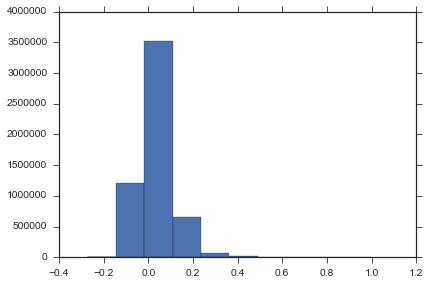

In [43]:
plt.hist(cor_transf.as_matrix().reshape([-1,1]))

0.05
0.0 1.0
0.075
0.0 1.0
0.1
0.0 1.0
0.125
0.0 1.0
0.15
0.0 1.0
0.175
0.0 1.0
0.2
0.0 1.0
0.4
0.0 1.0
0.5
0.0 1.0


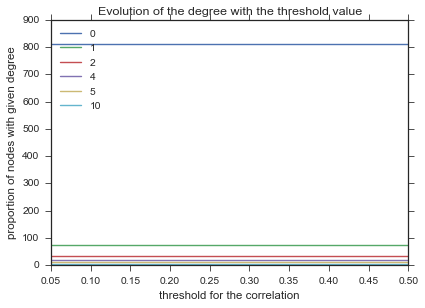

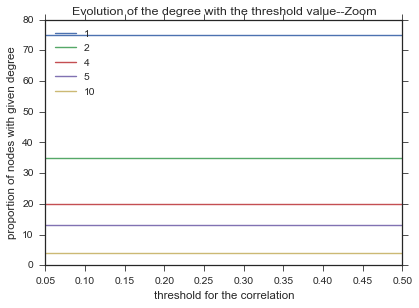

In [42]:
thres_array=np.sort([0.5,0.4,0.2,0.175,0.15,0.125,0.1,0.075,0.05])
degree_T=pd.DataFrame(np.zeros((Betas.shape[0],len(thres_array))),index=Betas.index,columns=thres_array)
consistency_T=pd.DataFrame(np.zeros((Betas.shape[0],len(thres_array))),index=Betas.index,columns=thres_array)
diversity_T=pd.DataFrame(np.zeros((Betas.shape[0],len(thres_array))),index=Betas.index,columns=thres_array)
for thres in thres_array:
    print thres
    cor_t=cor_transf.applymap(lambda x: x*(np.abs(x)>thres))
    print np.min(np.min(np.abs(cor_t))),np.max(np.max(np.abs(cor_t)))
    ## Check diag
    sector_consistency_temp=sector_consistence(Betas,cor_res)
    consistency_T[thres]=sector_consistency_temp['consistency']
    diversity_T[thres]=sector_consistency_temp['diversity']
    degree_T[thres]=sector_consistency_temp['degree']
    #plt.hist(sector_consistency_temp['diversity'])
    #plt.hist(sector_consistency_temp['consistency'],bins=30)
    #plt.hist(sector_consistency_temp['degree'],bins=30)
    
### Most consistent stocks per threshold\
l_T={}
overlap_T=pd.DataFrame(np.zeros((Betas.shape[0],len(thres_array))),index=Betas.index,columns=thres_array)
for thres in thres_array:
    l_T[thres]=consistency[thres][consistency[thres].argsort()>Betas.shape[0]-200]
    overlap.loc[l_T[thres].index,thres]+=1
plt.figure()
for d in [0,1,2,4,5,10]:    
    plt.plot(thres_array,[np.sum(degree_T[t]==d) for t in thres_array],label=d)
plt.xlabel('threshold for the correlation')
plt.ylabel('proportion of nodes with given degree')
plt.title('Evolution of the degree with the threshold value')
plt.legend(loc='upper left')
plt.show()



plt.figure()
for d in [1,2,4,5,10]:    
    plt.plot(thres_array,[np.sum(degree_T[t]==d) for t in thres_array],label=d)
plt.xlabel('threshold for the correlation')
plt.ylabel('proportion of nodes with given degree')
plt.title('Evolution of the degree with the threshold value--Zoom')
plt.legend(loc='upper left')
plt.show()

<h3><span style="color:purple">  Extending to other time frames </span></h3>